In [1]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

zip_file_name = list(uploaded.keys())[0]  # Get the name of the uploaded file


Saving Road Damages Detection.v7i.coco.zip to Road Damages Detection.v7i.coco.zip


In [2]:
# Create a directory to extract the contents
os.makedirs('/content/dataset', exist_ok=True)

# Extract the ZIP file into the created directory
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Clean up by removing the uploaded ZIP file if no longer needed
os.remove(zip_file_name)

In [3]:
# List the contents of the dataset directory
print("Contents of /content/dataset:")
print(os.listdir('/content/dataset'))

# Check the contents of each folder
print("Train directory:", os.listdir('/content/dataset/train'))
print("Validation directory:", os.listdir('/content/dataset/valid'))
print("Test directory:", os.listdir('/content/dataset/test'))


Contents of /content/dataset:
['train', 'valid', 'README.dataset.txt', 'README.roboflow.txt', 'test']
Train directory: ['Japan_002636_jpg.rf.b78353fad4bdda6f46ad51085d52dde4.jpg', 'Japan_002728_jpg.rf.dea80f950db3f4a21324176383559f1e.jpg', 'Japan_002968_jpg.rf.9c166942dd0244388552a64a00ef630b.jpg', 'Japan_003002_jpg.rf.f8bda77844f1d32df495b0aacdcd80a8.jpg', 'Japan_002016_jpg.rf.451f65f09b4eea53cef8dba0f0dd1820.jpg', 'Japan_002767_jpg.rf.480ec7cdf0906b22fec7d9109084b30d.jpg', 'Japan_000931_jpg.rf.285652157b02cb6d9c5d352feae074d1.jpg', 'Japan_003064_jpg.rf.19c1190aa670dfe0a7abf014e8b0ae6c.jpg', 'Japan_001360_jpg.rf.6d299618f33eca18e943f9d950f11b74.jpg', 'Japan_003113_jpg.rf.eb172d479537cf3221c8a6ba4d14b391.jpg', 'Japan_002196_jpg.rf.6a38741b28ada71fb85280814b472410.jpg', 'Japan_002803_jpg.rf.c2338dd07032fadfa21835c586cbf3c6.jpg', 'Japan_001991_jpg.rf.d02016d44c5b80fa0bde88f79dfac4b4.jpg', 'Japan_000077_jpg.rf.7da3e533c93c142b736b8b99c4a40ffc.jpg', 'Japan_000683_jpg.rf.7e3e34f4b39861ad135

In [4]:
# Install Detectron2
!pip install torch torchvision torchaudio
!pip install cython
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-88wzxwi5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-88wzxwi5
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 52.7 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [5]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances


In [6]:
# Register COCO format datasets
register_coco_instances("road_damage_train", {}, "/content/dataset/train/_annotations.coco.json", "/content/dataset/train")
register_coco_instances("road_damage_val", {}, "/content/dataset/valid/_annotations.coco.json", "/content/dataset/valid")
register_coco_instances("road_damage_test", {}, "/content/dataset/test/_annotations.coco.json", "/content/dataset/test")


In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("road_damage_train",)
cfg.DATASETS.TEST = ("road_damage_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# Initialize from pre-trained model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# Adjust learning rate and iterations as needed
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 3000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8

# Output directory for saving the model
cfg.OUTPUT_DIR = "/content/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [9]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[09/10 19:06:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 122MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[09/10 19:06:21 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/10 19:06:31 d2.utils.events]:  eta: 0:14:23  iter: 19  total_loss: 2.464  loss_cls: 2.079  loss_box_reg: 0.2662  loss_rpn_cls: 0.08877  loss_rpn_loc: 0.02085    time: 0.2882  last_time: 0.3014  data_time: 0.0165  last_data_time: 0.0050   lr: 1.9981e-05  max_mem: 1737M
[09/10 19:06:41 d2.utils.events]:  eta: 0:15:04  iter: 39  total_loss: 1.429  loss_cls: 1.034  loss_box_reg: 0.251  loss_rpn_cls: 0.05086  loss_rpn_loc: 0.02119    time: 0.2965  last_time: 0.2391  data_time: 0.0074  last_data_time: 0.0054   lr: 3.9961e-05  max_mem: 1737M
[09/10 19:06:48 d2.utils.events]:  eta: 0:15:10  iter: 59  total_loss: 0.6212  loss_cls: 0.3313  loss_box_reg: 0.2665  loss_rpn_cls: 0.00742  loss_rpn_loc: 0.01646    time: 0.2995  last_time: 0.3371  data_time: 0.0149  last_data_time: 0.0119   lr: 5.9941e-05  max_mem: 1737M
[09/10 19:06:53 d2.utils.events]:  eta: 0:14:43  iter: 79  total_loss: 0.5087  loss_cls: 0.228  loss_box_reg: 0.2644  loss_rpn_cls: 0.004623  loss_rpn_loc: 0.01229    time: 0.2956 

In [10]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("road_damage_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "road_damage_val")
inference_on_dataset(trainer.model, val_loader, evaluator)


WARNING [09/10 19:22:32 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [09/10 19:22:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/10 19:22:32 d2.data.datasets.coco]: Loaded 689 images in COCO format from /content/dataset/valid/_annotations.coco.json
[09/10 19:22:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/10 19:22:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/10 19:22:32 d2.data.common]: Serializing 689 elements to byte tensors and concatenating them all ...
[09/10 19:22:32 d2.data.common]: Serialized dataset takes 0.18 MiB
[09/10 19:22:32 d2.evaluation.evaluator]: Start inference on 689 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/10 19:22:33 d2.evaluation.evaluator]: Inference done 11/689. Dataloading: 0.0015 s/iter. Inference: 0.0805 s/iter. Eval: 0.0003 s/iter. Total: 0.0823 s/iter. ETA=0:00:55
[09/10 19:22:38 d2.evaluation.evaluator]: Inference done 72/689. Dataloading: 0.0017 s/iter. Inference: 0.0804 s/iter. Eval: 0.0003 s/iter. Total: 0.0825 s/iter. ETA=0:00:50
[09/10 19:22:43 d2.evaluation.evaluator]: Inference done 129/689. Dataloading: 0.0032 s/iter. Inference: 0.0814 s/iter. Eval: 0.0003 s/iter. Total: 0.0850 s/iter. ETA=0:00:47
[09/10 19:22:48 d2.evaluation.evaluator]: Inference done 188/689. Dataloading: 0.0029 s/iter. Inference: 0.0819 s/iter. Eval: 0.0003 s/iter. Total: 0.0852 s/iter. ETA=0:00:42
[09/10 19:22:53 d2.evaluation.evaluator]: Inference done 243/689. Dataloading: 0.0036 s/iter. Inference: 0.0826 s/iter. Eval: 0.0003 s/iter. Total: 0.0866 s/iter. ETA=0:00:38
[09/10 19:22:58 d2.evaluation.evaluator]: Inference done 297/689. Dataloading: 0.0041 s/iter. Inference: 0.0833 s/iter. Eval: 0

OrderedDict([('bbox',
              {'AP': 76.76142680043223,
               'AP50': 81.61568778255283,
               'AP75': 81.36594320502373,
               'APs': nan,
               'APm': nan,
               'APl': 76.76142680043223,
               'AP-Road-damages': nan,
               'AP-D00': 70.69281215109898,
               'AP-D10': 88.66115636225055,
               'AP-D20': 74.9590483988909,
               'AP-D40': 53.26413842418851,
               'AP-D43': 88.99314726491873,
               'AP-D44': 85.30141410306639,
               'AP-D50': 75.45827089861154})])

In [12]:
from detectron2.engine import DefaultPredictor

[09/10 19:29:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

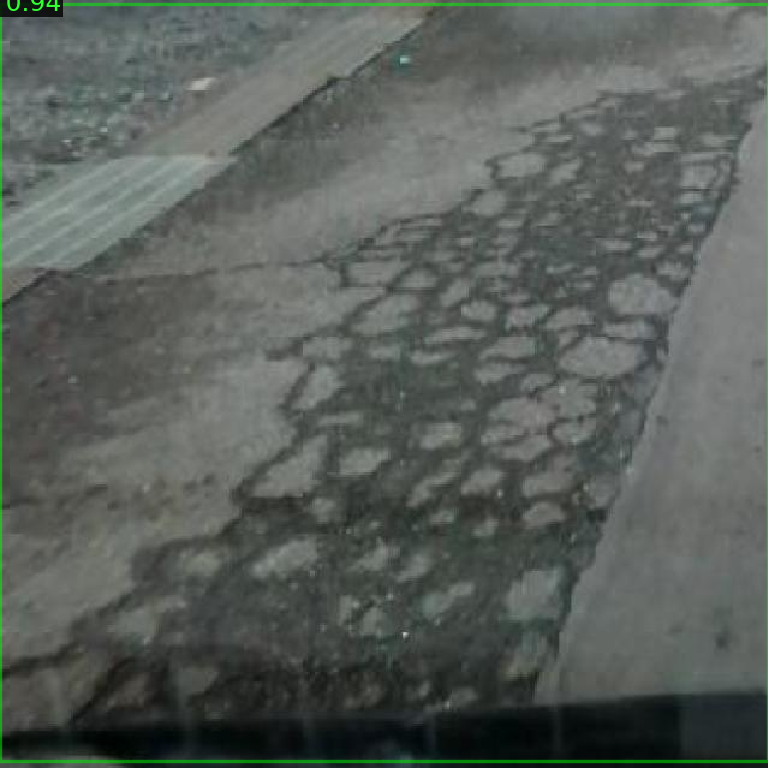

Best Prediction - Class: D20, Confidence: 0.94, Box: [0.0, 3.630078077316284, 640.0, 634.0768432617188]


In [15]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_001601_jpg.rf.ee7b9e7ebeafa392e85123c9342f19ae.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Extract predicted boxes, classes, and scores
pred_boxes = outputs["instances"].pred_boxes
pred_classes = outputs["instances"].pred_classes
pred_scores = outputs["instances"].scores

# Find the index of the prediction with the highest confidence score
max_score_idx = pred_scores.argmax().item()

# Extract the highest scoring prediction
best_box = pred_boxes[max_score_idx].tensor.tolist()[0]  # The best bounding box coordinates
best_class_idx = pred_classes[max_score_idx].item()  # The class index for the highest score
best_score = pred_scores[max_score_idx].item()  # The highest confidence score
best_class_name = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[best_class_idx]  # The class name for the highest score

# Visualize the result with the best prediction
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

# Draw the highest confidence prediction
v.draw_box(pred_boxes[max_score_idx].tensor[0].cpu(), edge_color=(0, 1, 0))  # Normalized color values
v.draw_text(f"{best_class_name}: {best_score:.2f}", (int(best_box[0]), int(best_box[1]) - 10), font_size=15, color=(0, 1, 0))

# Show the image with the best bounding box and prediction
out = v.get_output()
cv2_imshow(out.get_image()[:, :, ::-1])


# Print the highest confidence prediction details in the Colab output
print(f"Best Prediction - Class: {best_class_name}, Confidence: {best_score:.2f}, Box: {best_box}")


[09/10 19:30:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

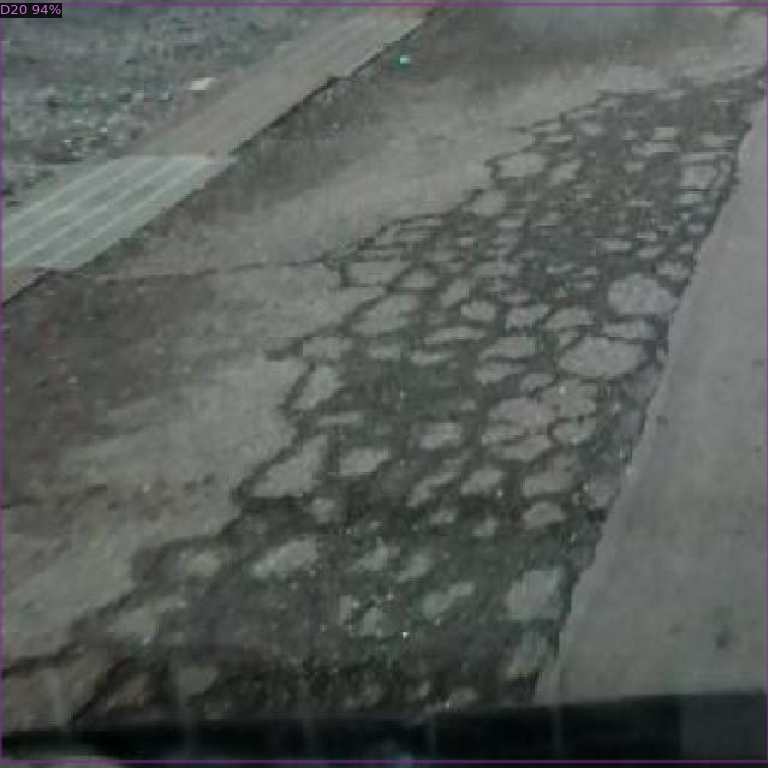

Boxes(tensor([[  0.0000,   3.6301, 640.0000, 634.0768]], device='cuda:0'))
tensor([3], device='cuda:0')


In [16]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_001601_jpg.rf.ee7b9e7ebeafa392e85123c9342f19ae.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices



[09/10 19:31:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

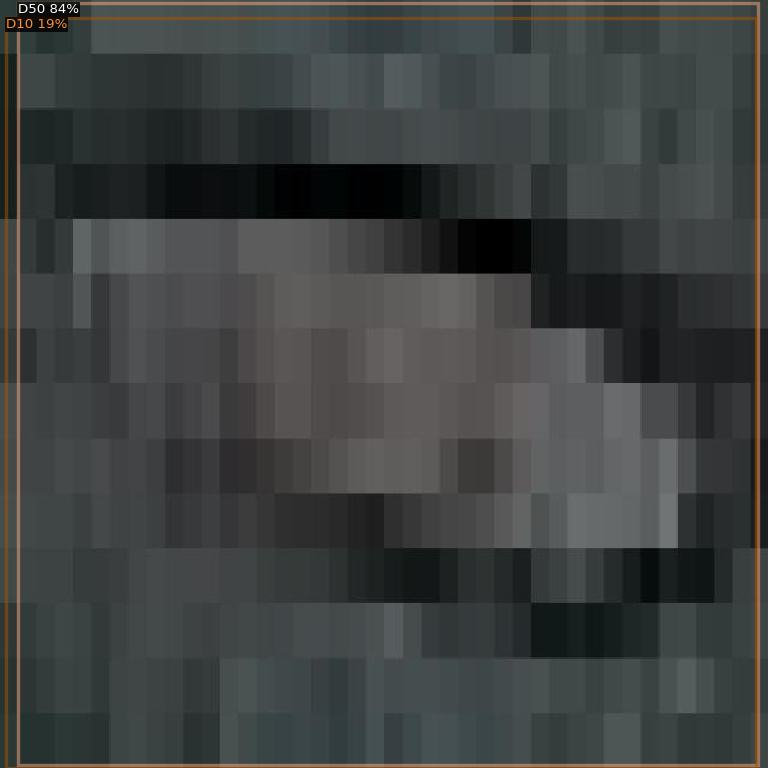

Boxes(tensor([[ 15.3378,   2.2008, 631.6816, 637.2098],
        [  4.9675,  15.3055, 629.6354, 640.0000]], device='cuda:0'))
tensor([7, 2], device='cuda:0')


In [17]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_002865_jpg.rf.7d4668cfebaca5485d9f167b8441dbb6.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices



[09/10 19:32:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

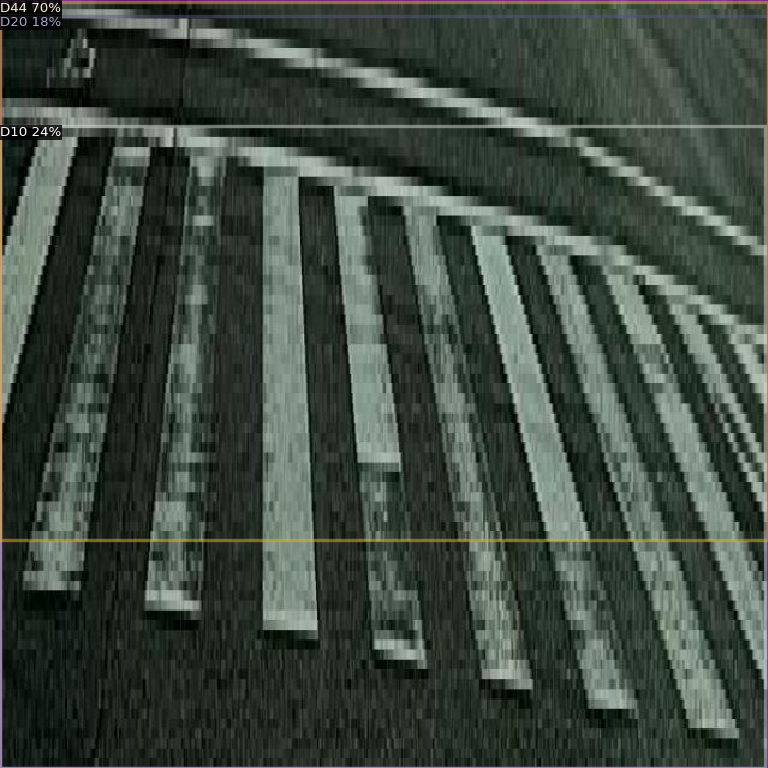

Boxes(tensor([[  0.0000,   1.6415, 640.0000, 449.6485],
        [  0.0000,   0.0000, 640.0000, 640.0000],
        [  0.0000, 105.2754, 637.4070, 640.0000],
        [  0.0000,  13.3810, 640.0000, 639.8971]], device='cuda:0'))
tensor([6, 5, 2, 3], device='cuda:0')


In [18]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_002644_jpg.rf.3c9c22f93b74333ffda647aed78db672.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices



[09/10 19:33:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

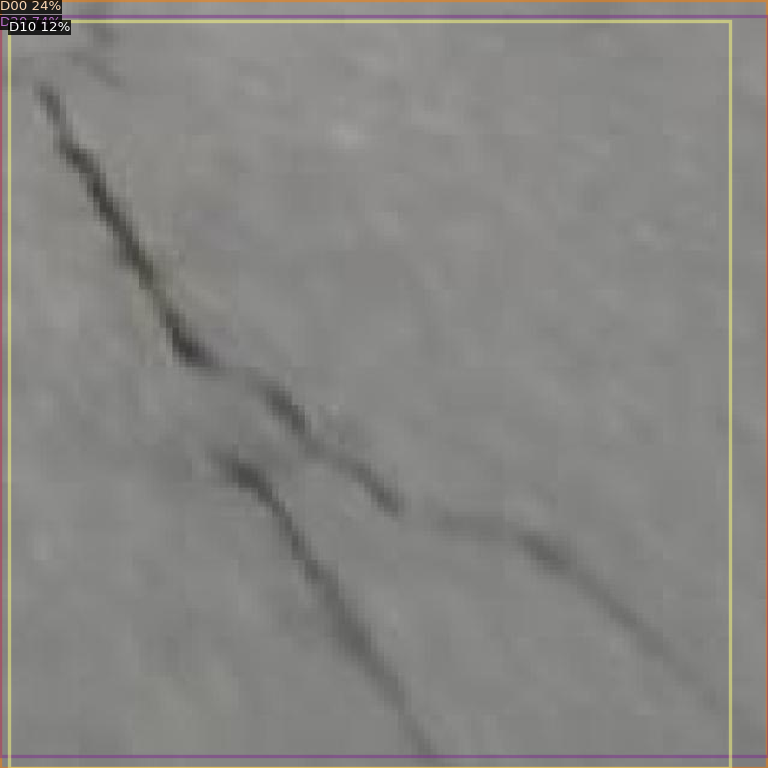

Boxes(tensor([[  0.0000,  13.6064, 640.0000, 629.6579],
        [  0.0000,   0.0000, 638.8891, 639.7971],
        [  7.1354,  17.1984, 608.5930, 640.0000]], device='cuda:0'))
tensor([3, 1, 2], device='cuda:0')


In [19]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_002697_jpg.rf.4a93c1976b4fc61402ff8e800979ff90.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices



[09/10 19:35:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

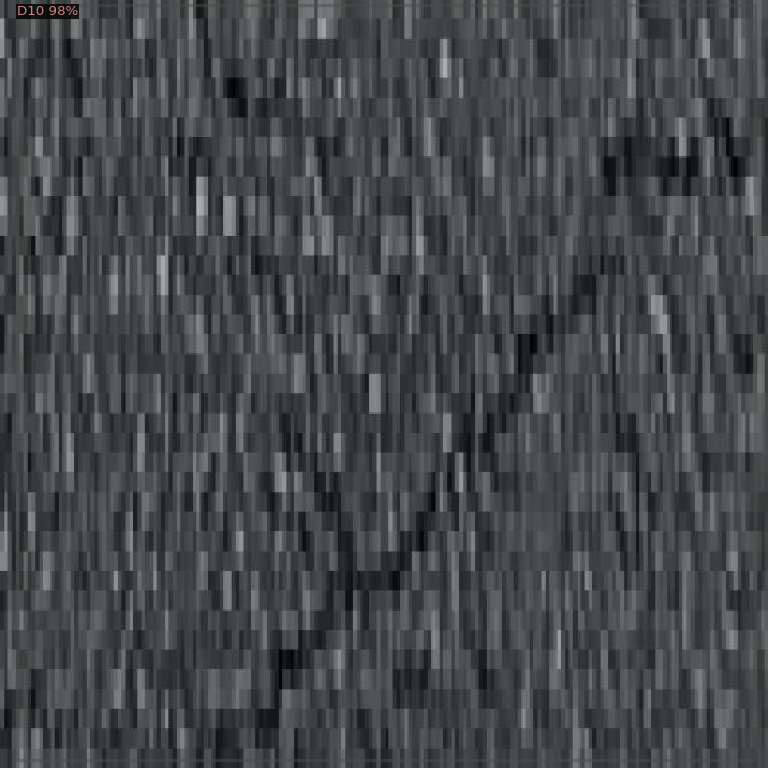

Boxes(tensor([[ 13.8100,   4.1487, 629.0634, 633.6201]], device='cuda:0'))
tensor([2], device='cuda:0')


In [20]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_002685_jpg.rf.595836bb026520cd341e48197cb75522.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices



[09/10 19:35:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

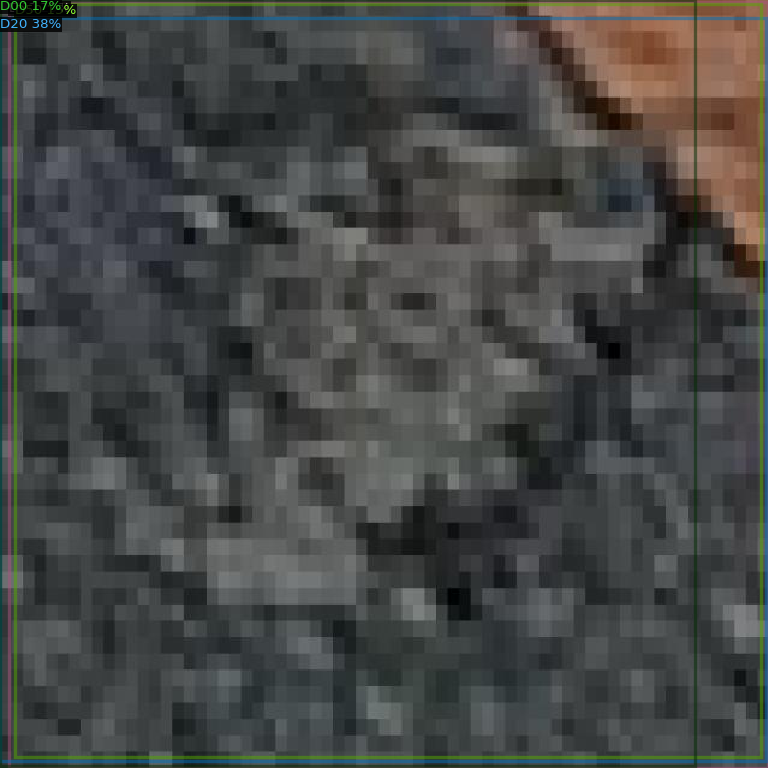

Boxes(tensor([[  0.0000,  14.6526, 638.7032, 634.0171],
        [  7.3970,   1.3837, 640.0000, 640.0000],
        [  0.0000,   0.0000, 579.2467, 638.7128],
        [ 12.1194,   3.7146, 633.9885, 630.7212]], device='cuda:0'))
tensor([3, 4, 1, 7], device='cuda:0')


In [21]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_003169_jpg.rf.f1942c4a72327ea9c78e00fbf05ba046.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices



[09/10 19:36:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

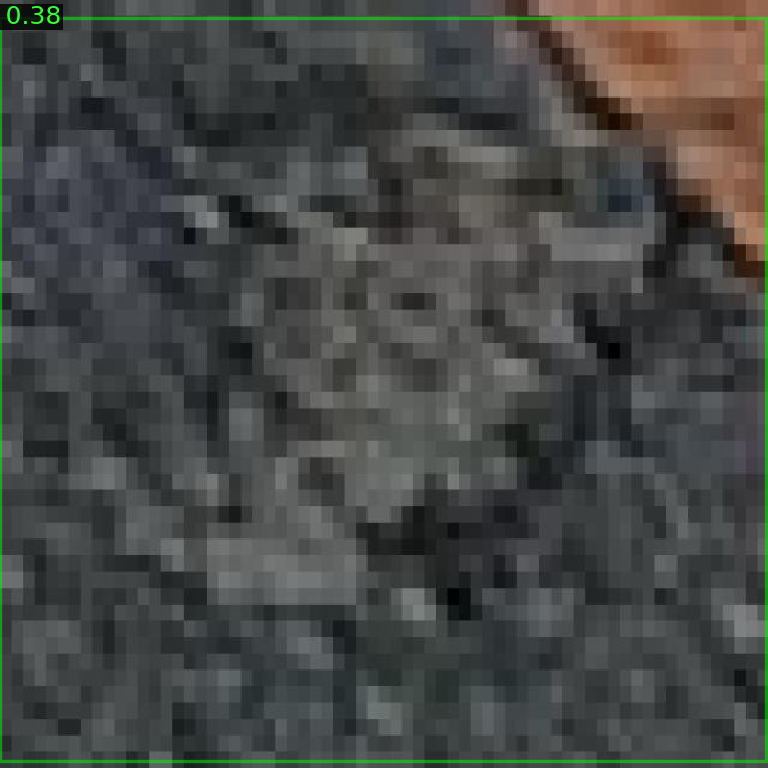

Best Prediction - Class: D20, Confidence: 0.38, Box: [0.0, 14.65256404876709, 638.7032470703125, 634.01708984375]


In [23]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_003169_jpg.rf.f1942c4a72327ea9c78e00fbf05ba046.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Extract predicted boxes, classes, and scores
pred_boxes = outputs["instances"].pred_boxes
pred_classes = outputs["instances"].pred_classes
pred_scores = outputs["instances"].scores

# Find the index of the prediction with the highest confidence score
max_score_idx = pred_scores.argmax().item()

# Extract the highest scoring prediction
best_box = pred_boxes[max_score_idx].tensor.tolist()[0]  # The best bounding box coordinates
best_class_idx = pred_classes[max_score_idx].item()  # The class index for the highest score
best_score = pred_scores[max_score_idx].item()  # The highest confidence score
best_class_name = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[best_class_idx]  # The class name for the highest score

# Visualize the result with the best prediction
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

# Draw the highest confidence prediction
v.draw_box(pred_boxes[max_score_idx].tensor[0].cpu(), edge_color=(0, 1, 0))  # Normalized color values
v.draw_text(f"{best_class_name}: {best_score:.2f}", (int(best_box[0]), int(best_box[1]) - 10), font_size=15, color=(0, 1, 0))

# Show the image with the best bounding box and prediction
out = v.get_output()
cv2_imshow(out.get_image()[:, :, ::-1])


# Print the highest confidence prediction details in the Colab output
print(f"Best Prediction - Class: {best_class_name}, Confidence: {best_score:.2f}, Box: {best_box}")


[09/10 19:39:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

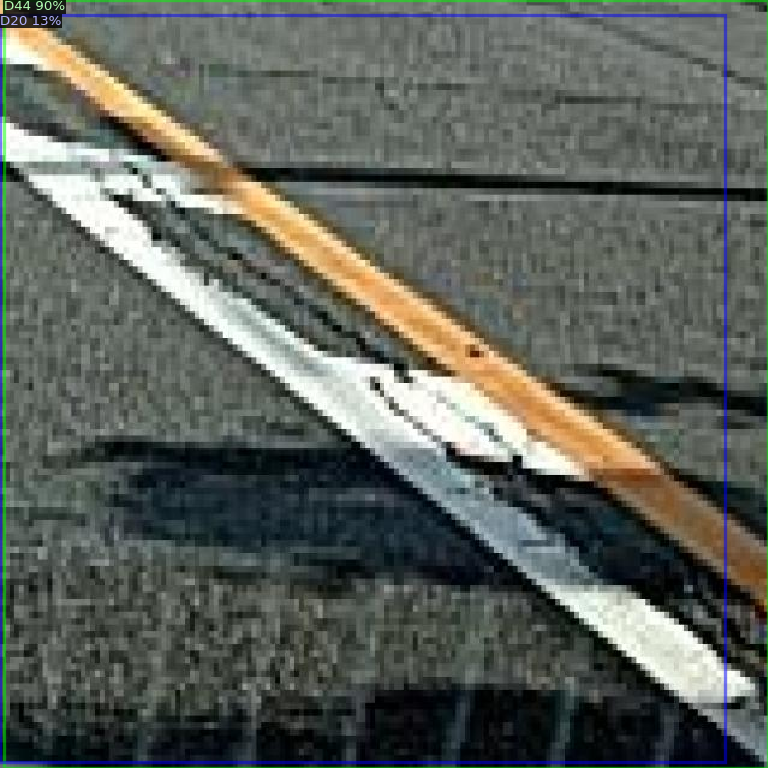

Boxes(tensor([[  3.2081,   0.0000, 640.0000, 640.0000],
        [  0.0000,  12.1071, 603.8499, 634.6322]], device='cuda:0'))
tensor([6, 3], device='cuda:0')


In [24]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_002980_jpg.rf.608dc30ce5052b56f4852291e01c5ce5.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices



[09/10 19:57:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

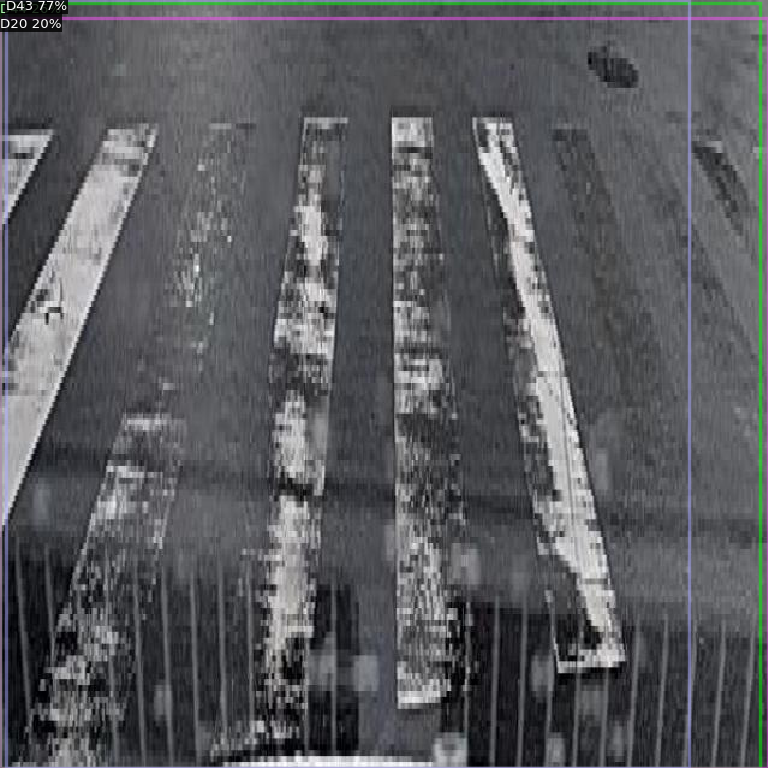

Boxes(tensor([[  5.0034,   0.0000, 574.2055, 640.0000],
        [  0.0000,   2.7758, 633.4609, 640.0000],
        [  0.0000,  14.9243, 640.0000, 640.0000]], device='cuda:0'))
tensor([5, 6, 3], device='cuda:0')


In [25]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_000002_jpg.rf.6b9464b51c2a394f22e0f5e6dd2a96b7.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices



[09/10 20:04:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

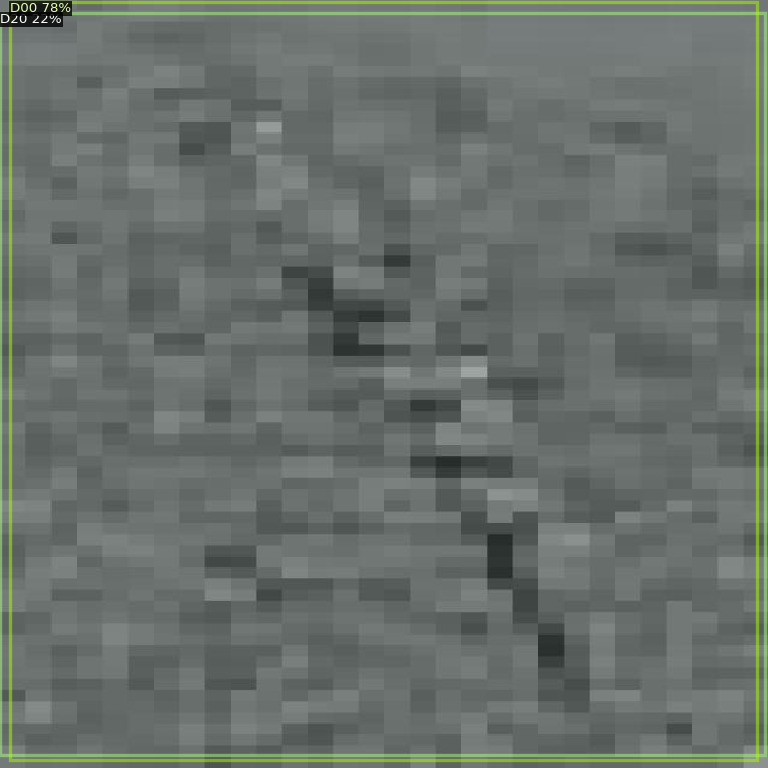

Boxes(tensor([[  8.3369,   1.4615, 631.2404, 633.0781],
        [  0.0000,  11.1285, 637.9042, 629.4248]], device='cuda:0'))
tensor([1, 3], device='cuda:0')


In [26]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_000067_jpg.rf.46db4c111be041930fc6e5c11a20e423.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices


[09/10 20:08:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

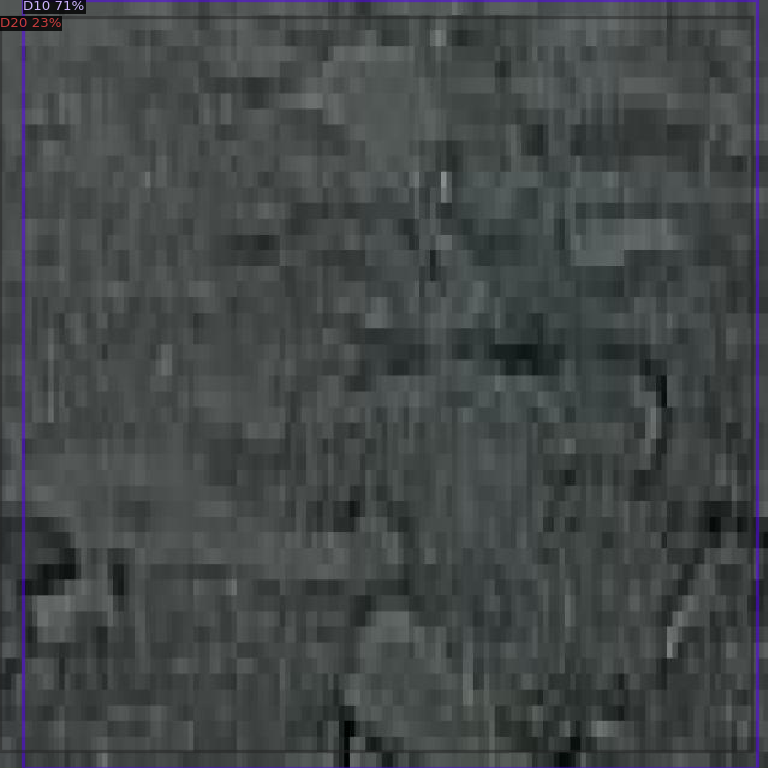

Boxes(tensor([[ 19.5750,   0.0000, 630.6701, 640.0000],
        [  0.0000,  14.5347, 627.0119, 626.1508]], device='cuda:0'))
tensor([2, 3], device='cuda:0')


In [27]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_000068_jpg.rf.d9f2bf2d238fe9d696a20d1dbef3e304.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices


[09/10 20:16:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

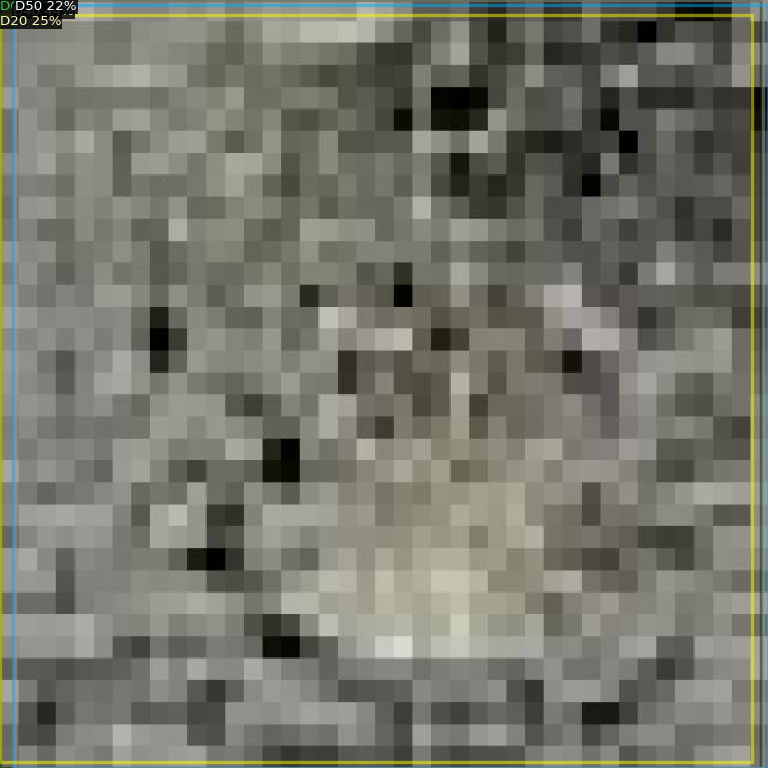

Boxes(tensor([[ 11.0981,   4.2308, 640.0000, 640.0000],
        [  0.0000,  12.7786, 626.7816, 634.9425],
        [ 12.6477,   0.0000, 635.7464, 640.0000],
        [  0.0000,   0.0000, 634.0580, 640.0000]], device='cuda:0'))
tensor([4, 3, 7, 1], device='cuda:0')


In [33]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_000184_jpg.rf.d3d9b13ee264659fe75fe08d72242597.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices


[09/10 20:16:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

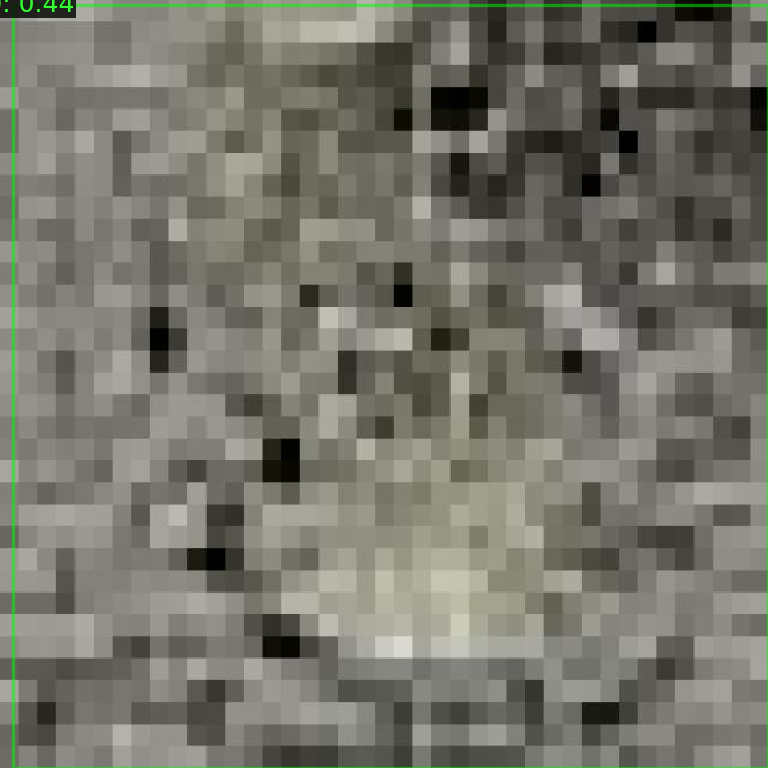

Best Prediction - Class: D40, Confidence: 0.44, Box: [11.09814453125, 4.230786323547363, 640.0, 640.0]


In [31]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_000184_jpg.rf.d3d9b13ee264659fe75fe08d72242597.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Extract predicted boxes, classes, and scores
pred_boxes = outputs["instances"].pred_boxes
pred_classes = outputs["instances"].pred_classes
pred_scores = outputs["instances"].scores

# Find the index of the prediction with the highest confidence score
max_score_idx = pred_scores.argmax().item()

# Extract the highest scoring prediction
best_box = pred_boxes[max_score_idx].tensor.tolist()[0]  # The best bounding box coordinates
best_class_idx = pred_classes[max_score_idx].item()  # The class index for the highest score
best_score = pred_scores[max_score_idx].item()  # The highest confidence score
best_class_name = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[best_class_idx]  # The class name for the highest score

# Visualize the result with the best prediction
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

# Draw the highest confidence prediction
v.draw_box(pred_boxes[max_score_idx].tensor[0].cpu(), edge_color=(0, 1, 0))  # Normalized color values
v.draw_text(f"{best_class_name}: {best_score:.2f}", (int(best_box[0]), int(best_box[1]) - 10), font_size=15, color=(0, 1, 0))

# Show the image with the best bounding box and prediction
out = v.get_output()
cv2_imshow(out.get_image()[:, :, ::-1])


# Print the highest confidence prediction details in the Colab output
print(f"Best Prediction - Class: {best_class_name}, Confidence: {best_score:.2f}, Box: {best_box}")

[09/10 19:25:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

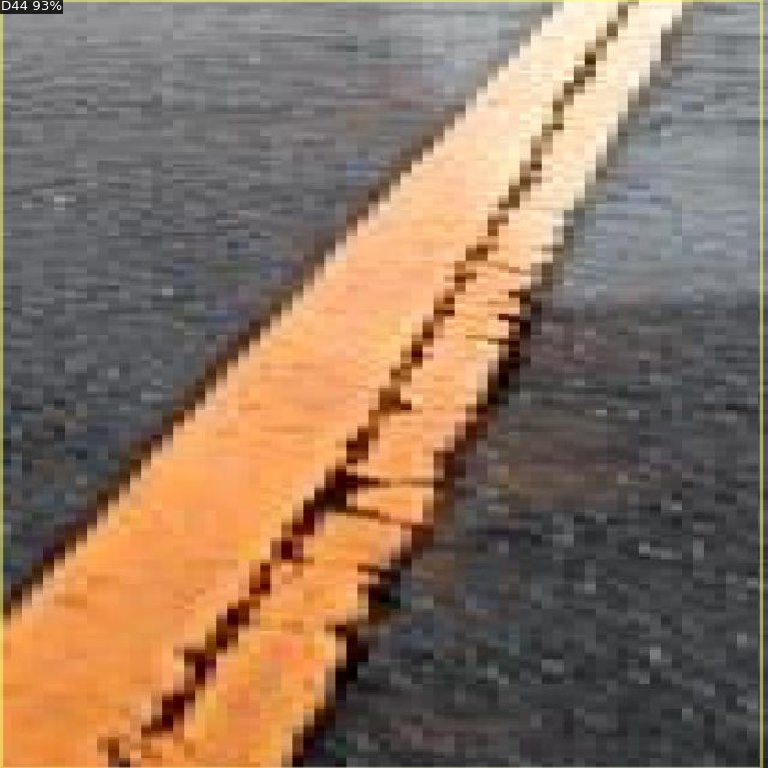

Boxes(tensor([[  1.1804,   0.0000, 634.2487, 640.0000]], device='cuda:0'))
tensor([6], device='cuda:0')


In [13]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_002763_jpg.rf.2c0591cafb189da01d68ec0cfa1f0e6b.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices



[09/10 19:26:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

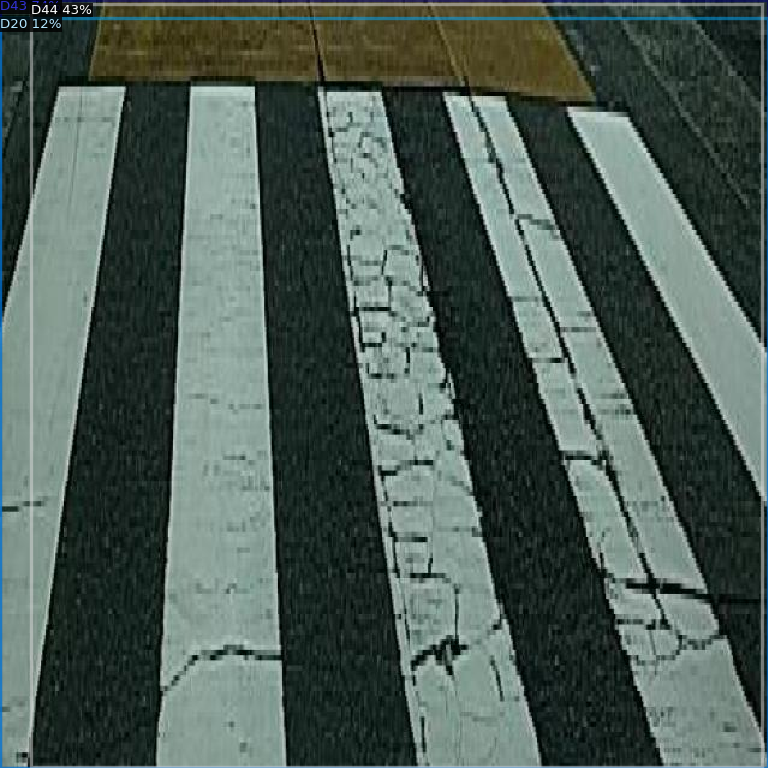

Boxes(tensor([[  0.0000,   0.0000, 640.0000, 640.0000],
        [ 25.9204,   2.9307, 634.9087, 638.8136],
        [  0.0000,  15.2654, 640.0000, 640.0000]], device='cuda:0'))
tensor([5, 6, 3], device='cuda:0')


In [14]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_002117_jpg.rf.8fb35cd07741e7d31f8d01d454c8d6bf.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices



[09/05 18:27:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

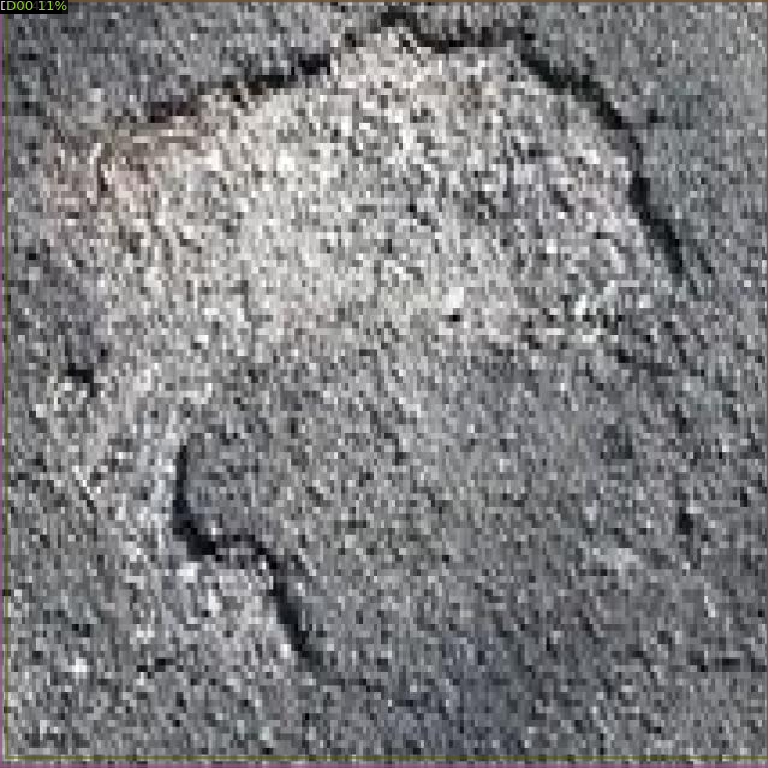

Boxes(tensor([[  0.0000,   0.0000, 640.0000, 638.8635],
        [  0.0000,   0.0000, 640.0000, 637.4626],
        [  4.5993,   0.0000, 640.0000, 630.9207]], device='cuda:0'))
tensor([3, 6, 1], device='cuda:0')


In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_000899_jpg.rf.771129904d7a6e984a0ca1d8c7b3ba85.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices


[09/05 18:29:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

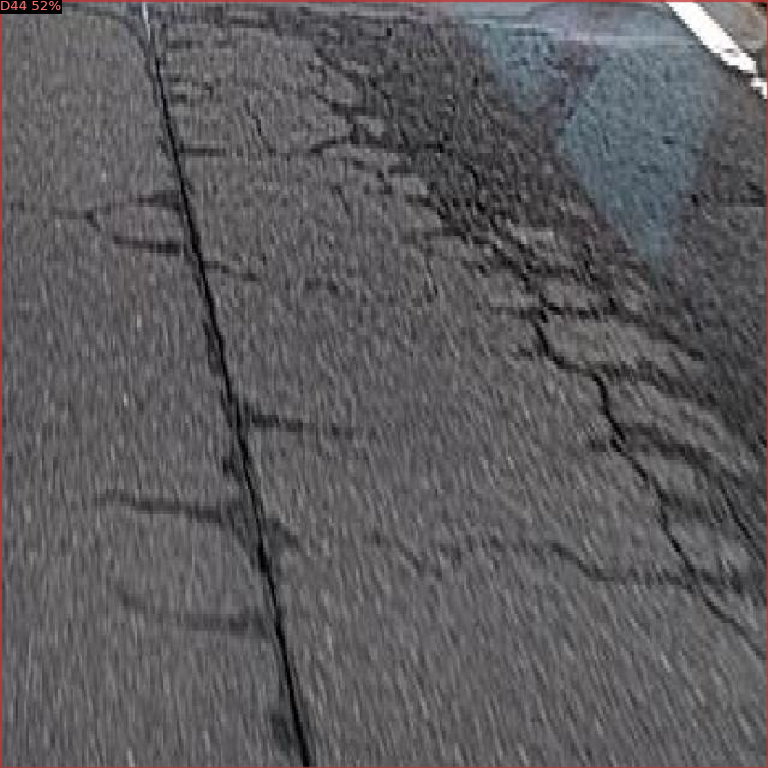

Boxes(tensor([[  0.,   0., 640., 640.],
        [  0.,   0., 640., 640.]], device='cuda:0'))
tensor([3, 6], device='cuda:0')


In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_000438_jpg.rf.579cfb8a917aca59863f56d974a74b77.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices


[09/05 18:32:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

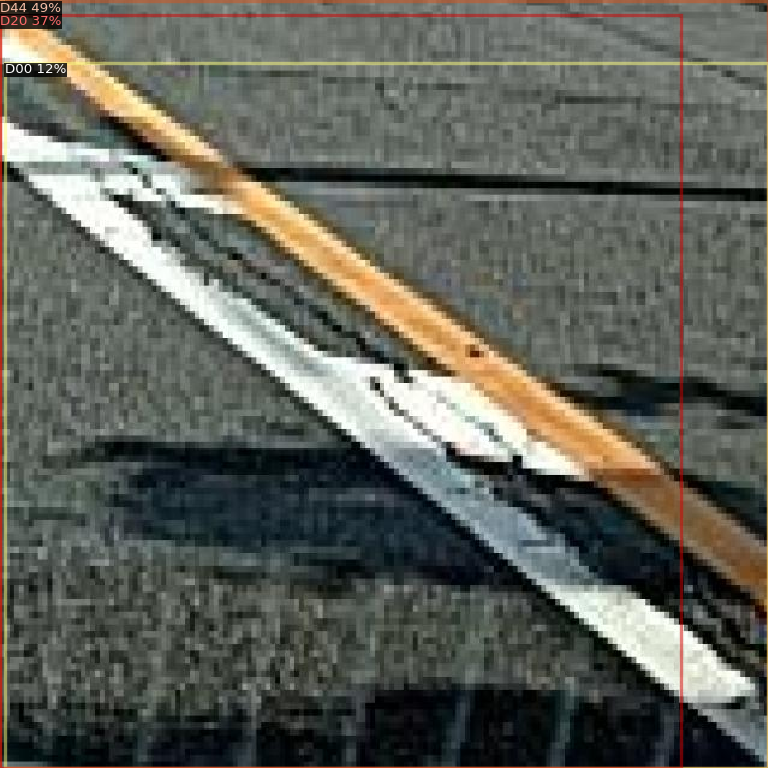

Boxes(tensor([[  0.0000,   1.2565, 640.0000, 640.0000],
        [  0.0000,  12.3634, 567.6452, 640.0000],
        [  3.7874,  52.8750, 640.0000, 640.0000]], device='cuda:0'))
tensor([6, 3, 1], device='cuda:0')


In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_002980_jpg.rf.608dc30ce5052b56f4852291e01c5ce5.jpg"  # Replace with your specific image path
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices


[09/05 18:39:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

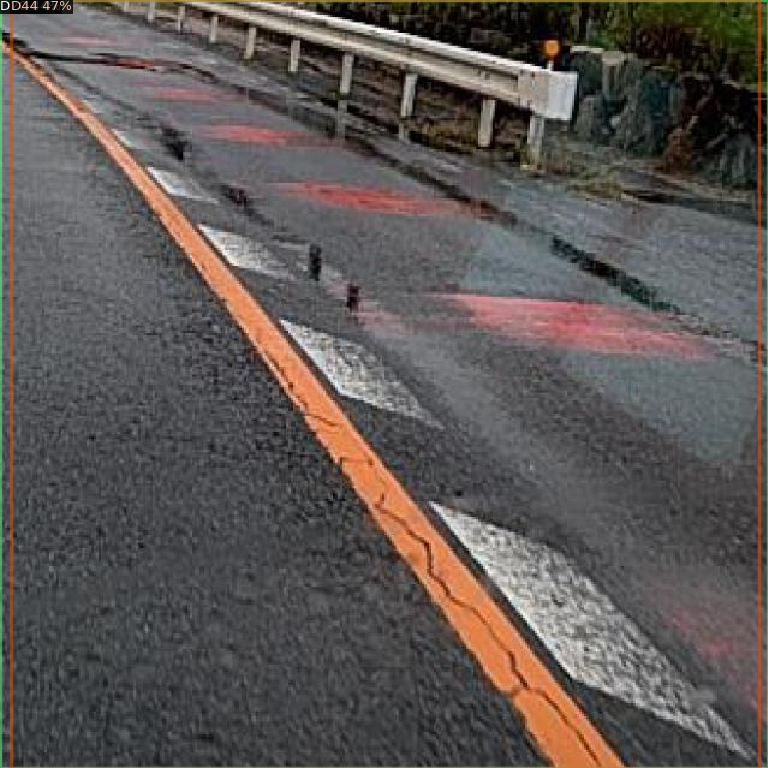

Boxes(tensor([[  8.9141,   0.0000, 632.7218, 640.0000],
        [  0.0000,   0.0000, 640.0000, 640.0000]], device='cuda:0'))
tensor([6, 3], device='cuda:0')


In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_001430_jpg.rf.a97a9fc3b82e5ec6358375b69af7e01f.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices

[09/05 18:44:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

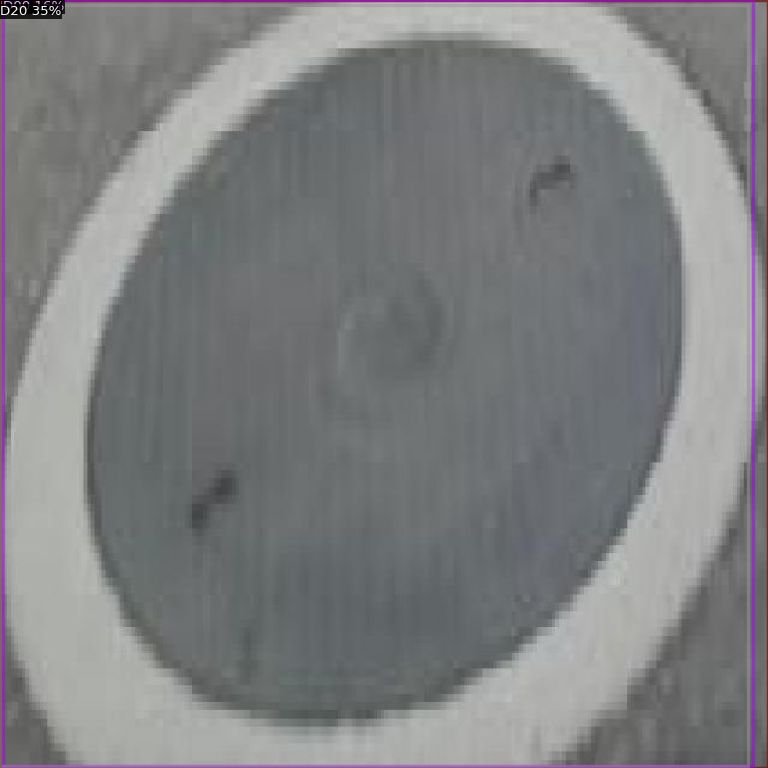

Boxes(tensor([[  0.0000,   0.0000, 640.0000, 640.0000],
        [  0.0000,   4.3775, 623.6769, 638.6118],
        [  2.2438,   0.0000, 627.5812, 637.9803],
        [  0.0000,   0.0000, 640.0000, 640.0000]], device='cuda:0'))
tensor([6, 3, 1, 2], device='cuda:0')


In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_001926_jpg.rf.d09132618bbfb970b4af3f80fe10f97a.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices

[09/05 18:43:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

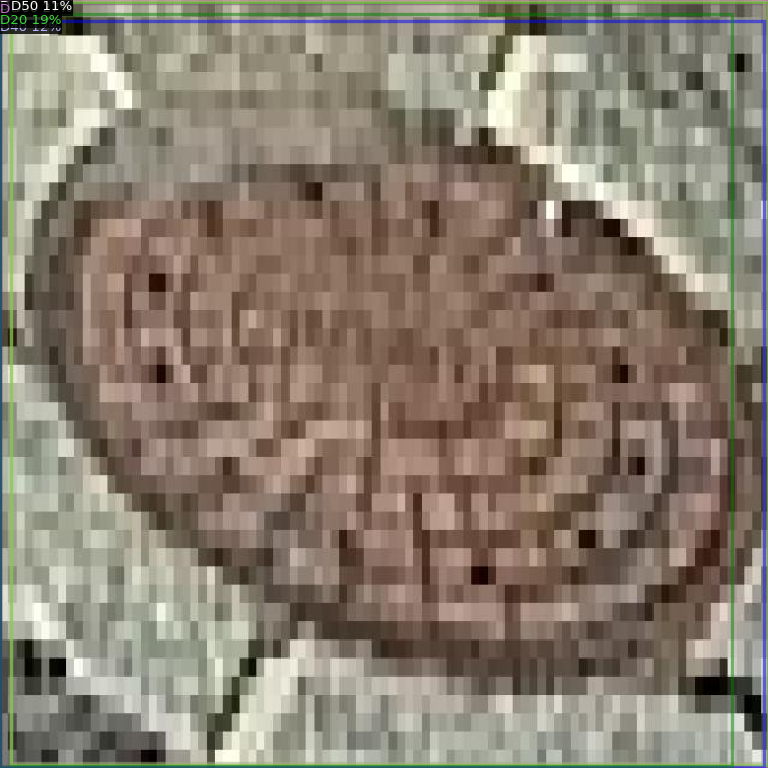

Boxes(tensor([[  0.0000,   2.3473, 640.0000, 640.0000],
        [  9.2037,   1.7541, 640.0000, 637.8173],
        [  0.0000,  11.5755, 609.8358, 638.2510],
        [  0.0000,   0.0000, 640.0000, 638.1989],
        [  0.0000,  17.0935, 636.2425, 638.9306],
        [  8.8560,   0.0000, 636.5796, 636.0609]], device='cuda:0'))
tensor([6, 1, 3, 2, 4, 7], device='cuda:0')


In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_000184_jpg.rf.3cca7fd725b90a7a205c1a14fcf6fa4a.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices

[09/05 18:45:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

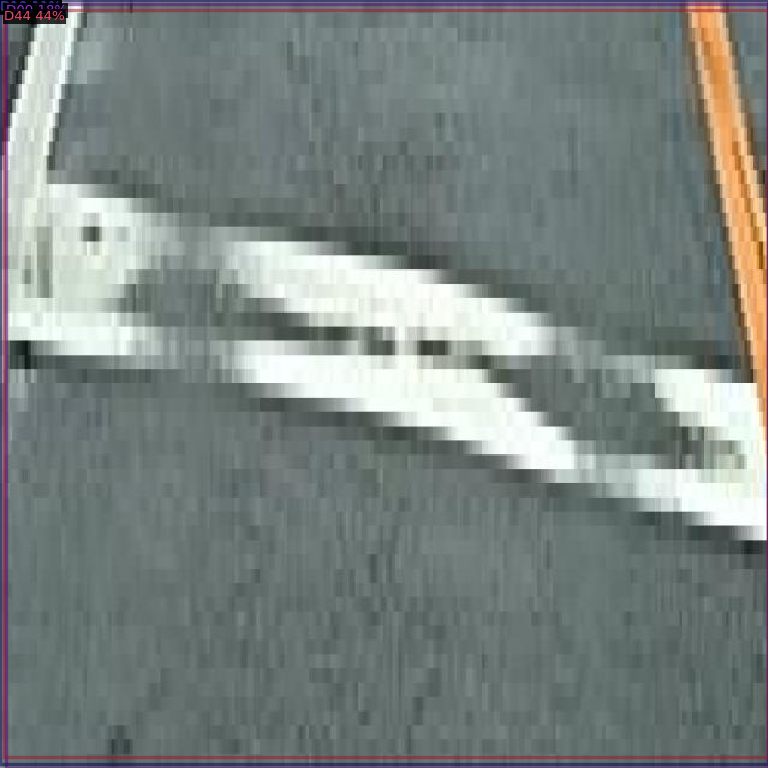

Boxes(tensor([[  3.6027,   8.1401, 640.0000, 630.8481],
        [  0.0000,   0.7673, 640.0000, 640.0000],
        [  4.8418,   3.1840, 640.0000, 640.0000],
        [  0.0000,   0.0000, 640.0000, 636.4531]], device='cuda:0'))
tensor([6, 3, 1, 2], device='cuda:0')


In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_000266_jpg.rf.ecab1d0576fd301adf054f343a5330a6.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices

[09/05 18:47:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

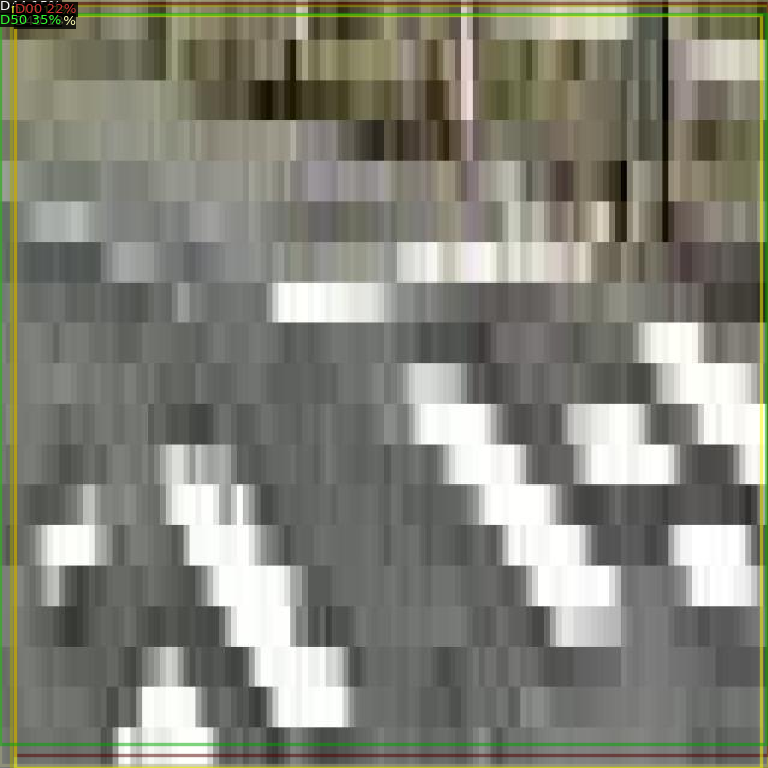

Boxes(tensor([[  0.0000,  11.2865, 638.6147, 620.1749],
        [ 12.7764,   2.3605, 640.0000, 629.3672],
        [ 12.1353,  12.1574, 633.8187, 640.0000],
        [  9.4569,   4.4198, 640.0000, 640.0000],
        [  0.0000,   0.0000, 640.0000, 637.8117]], device='cuda:0'))
tensor([7, 1, 4, 2, 6], device='cuda:0')


In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import os

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set the threshold to 0.1 to see more predictions

predictor = DefaultPredictor(cfg)

img_path = "/content/dataset/test/Japan_003073_jpg.rf.295732ec286044593fbe29caa9277057.jpg"
img = cv2.imread(img_path)

# Perform inference (make predictions on the image)
outputs = predictor(img)

# Visualize the results with bounding boxes
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show the image with bounding boxes
cv2_imshow(out.get_image()[:, :, ::-1])

# Check the predicted bounding boxes and classes
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_classes)  # This will give the predicted class indices

In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# Register the test dataset in COCO format
register_coco_instances("road_damage_test", {}, "/content/dataset/test/_annotations.coco.json", "/content/dataset/test")

# Load the test dataset
dataset_dicts = DatasetCatalog.get("road_damage_test")
metadata = MetadataCatalog.get("road_damage_test")

# Count instances per class
class_counts = {}
for data in dataset_dicts:
    for annotation in data["annotations"]:
        category_id = annotation["category_id"]
        class_name = metadata.thing_classes[category_id]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

# Print the instance counts per class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")


WARNING [09/09 13:59:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/09 13:59:47 d2.data.datasets.coco]: Loaded 402 images in COCO format from /content/dataset/test/_annotations.coco.json
Class: D00, Count: 75
Class: D44, Count: 75
Class: D20, Count: 91
Class: D50, Count: 58
Class: D10, Count: 60
Class: D40, Count: 31
Class: D43, Count: 12


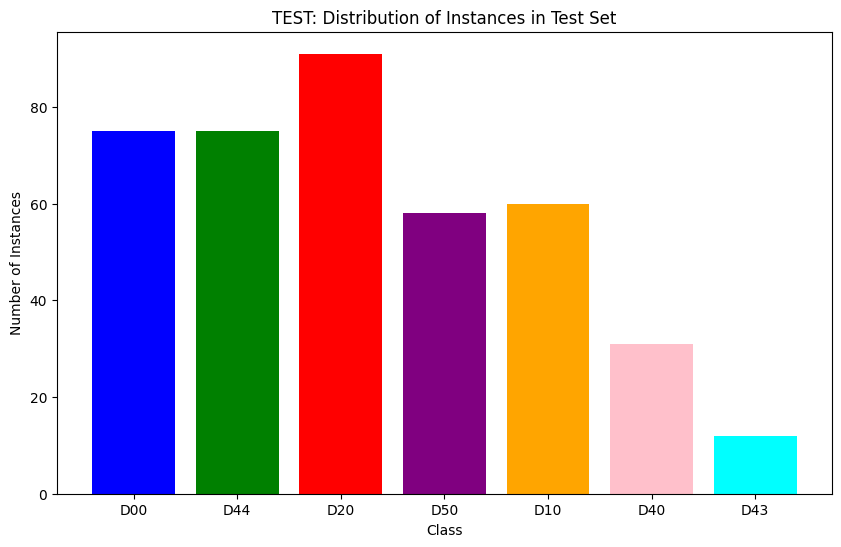

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the class names and their respective counts
class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Create a bar chart with different colors for each class
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color=['blue', 'green', 'red', 'purple', 'orange', 'pink', 'cyan'])

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('TEST: Distribution of Instances in Test Set')

# Show the plot
plt.show()


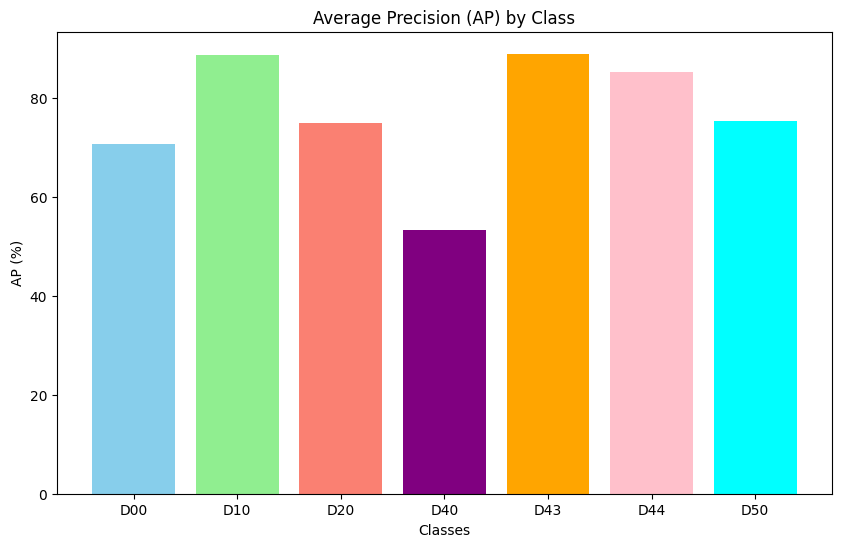

In [35]:
import matplotlib.pyplot as plt

# Define the classes and the consistent color scheme
classes = ['D00', 'D10', 'D20', 'D40', 'D43', 'D44', 'D50']
colors = ['skyblue', 'lightgreen', 'salmon', 'purple', 'orange', 'pink', 'cyan']

ap_scores = [70.693, 88.661, 74.959, 53.264, 88.993, 85.301, 75.458]

# Create a bar chart for Average Precision (AP) by class
plt.figure(figsize=(10, 6))
plt.bar(classes, ap_scores, color=colors)
plt.xlabel('Classes')
plt.ylabel('AP (%)')
plt.title('Average Precision (AP) by Class')
plt.show()

class_counts = {
    'D00': 392, 'D10': 381, 'D20': 611,
    'D40': 226, 'D43': 65, 'D44': 393, 'D50': 347
}





In [ ]:
!cp -r /content/output /content/drive/MyDrive/
